In [1]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV, KFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, f1_score, roc_curve, auc
from sklearn.kernel_approximation import Nystroem
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import metrics
from sklearn.metrics import f1_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.metrics import classification_report_imbalanced
from sklearn import neighbors

In [2]:
file = open('../../../conf/global_conf.yml', 'r') 
conf = yaml.safe_load(file)
df = pd.read_csv(conf['local_data_path'] + "data_cleaned_final_sans_dummies.csv",index_col=0,low_memory=False)
print(df.shape)

(447136, 43)


In [3]:
# Recoder grav par ordre de gravié croissant
print(df.grav_rec.value_counts())

df['grav2'] = df['grav_rec'].replace(['Indemne', 'Blessé léger', 'Blessé hospitalisé', 'Tué'],
                        [1, 2, 3, 4]) 


df.grav2.dtype

grav_rec
Indemne               184548
Blessé léger          180388
Blessé hospitalisé     69999
Tué                    12201
Name: count, dtype: int64


C:\Users\c.pelat\AppData\Local\Temp\ipykernel_14616\2940931926.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['grav2'] = df['grav_rec'].replace(['Indemne', 'Blessé léger', 'Blessé hospitalisé', 'Tué'],


dtype('int64')

In [146]:
# drop des données inutiles
data = df.drop(['grav', 'grav_rec', 'grav2', 'jour', 'date', 'dep', 'an'], axis=1) # 
y = df.grav2

In [147]:
print(data.columns)

Index(['mois', 'lum', 'agg', 'int', 'atm', 'col', 'lat', 'long', 'catr',
       'circ', 'prof', 'plan', 'surf', 'infra', 'situ', 'sexe', 'catv', 'obs',
       'obsm', 'manv', 'motor', 'weekend', 'heure', 'place_rec', 'age_usager',
       'eq_ceinture', 'eq_casque', 'eq_siege', 'eq_gilet', 'eq_airbag',
       'eq_gants', 'eq_indetermine', 'eq_autre', 'jour_chome', 'prox_pt_choc'],
      dtype='object')


In [148]:
numerical_features = ['age_usager', 'mois', 'heure', 'lat', 'long']
categorical_features = [col for col in data.columns if col not in numerical_features]
data[categorical_features] = data[categorical_features].astype('object')

In [149]:
# Quelles sont les categorical features non-binaires ?
nb_cat = data[categorical_features].apply(lambda x: x.nunique()) 
var_cat_mult = nb_cat[nb_cat > 2].index.tolist()
var_cat_mult

['lum',
 'col',
 'catr',
 'surf',
 'infra',
 'situ',
 'catv',
 'obsm',
 'manv',
 'motor',
 'place_rec']

# Scission en un ensemble d'apprentissage et un ensemble de test

In [150]:
data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42, stratify=y)

# Transformation des variables

Transformateur pour le passage en sin/cos des heures, et des mois

In [151]:
class TransfoHour(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transfo = X.copy()
        X_transfo[f'{self.column_name}_sin'] = np.sin(X_transfo[self.column_name]*(2.*np.pi/24))
        X_transfo[f'{self.column_name}_cos'] = np.cos(X_transfo[self.column_name]*(2.*np.pi/24))
        X_transfo = X_transfo.drop(self.column_name, axis=1)
        return X_transfo
    
    def get_feature_names_out(self):
        pass


class TransfoMonth(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transfo = X.copy()
        X_transfo[f'{self.column_name}_sin'] = np.sin((X_transfo[self.column_name]-1)*(2.*np.pi/12))
        X_transfo[f'{self.column_name}_cos'] = np.cos((X_transfo[self.column_name]-1)*(2.*np.pi/12))
        X_transfo = X_transfo.drop(self.column_name, axis=1)
        return X_transfo

    def get_feature_names_out(self):
        pass
    

## Création des transformers

In [152]:
var_cat_mult

['lum',
 'col',
 'catr',
 'surf',
 'infra',
 'situ',
 'catv',
 'obsm',
 'manv',
 'motor',
 'place_rec']

In [153]:
preprocessor = ColumnTransformer(transformers=[
    ("transfo_heure", TransfoHour('heure'), ['heure']),
    ("transfo_mois", TransfoMonth('mois'), ['mois']),
    ("transfo_lat_long", RobustScaler(), ['lat', 'long']),
    ('transfo_age_usager', StandardScaler(), ['age_usager']),
    ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False),  var_cat_mult )],
    #['place_rec','catr', 'surf', 'infra', 'situ', 'motor', 'manv', 'obsm', 'catv', 'col', 'lum', 'nb_usagers_gr']
    remainder="passthrough"
).set_output(transform="pandas")

preprocessor_dropfirst = ColumnTransformer(transformers=[
    ("transfo_heure", TransfoHour('heure'), ['heure']),
    ("transfo_mois", TransfoMonth('mois'), ['mois']),
    ("transfo_lat_long", RobustScaler(), ['lat', 'long']),
    ('transfo_age_usager', StandardScaler(), ['age_usager']),
    ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='first'), var_cat_mult )],
    remainder="passthrough"
).set_output(transform="pandas")

## Transformation sur la base de données
### train & test en gardant toutes les dummies

In [154]:
# Train : fit and transform
X_train_preprocessed = preprocessor.fit_transform(data_train)
X_train_preprocessed = X_train_preprocessed.infer_objects() # Convertir les types objects qui reste en integer
display(X_train_preprocessed.head())
print(X_train_preprocessed.shape)

# Test
X_test_preprocessed = preprocessor.transform(data_test)
X_test_preprocessed = X_test_preprocessed.infer_objects() # Convertir les types objects qui reste en integer
display(X_test_preprocessed.head())
print(X_test_preprocessed.shape)

,transfo_heure__heure_sin,transfo_heure__heure_cos,transfo_mois__mois_sin,transfo_mois__mois_cos,transfo_lat_long__lat,transfo_lat_long__long,transfo_age_usager__age_usager,one_hot_encoder__lum_0.0,one_hot_encoder__lum_1.0,one_hot_encoder__lum_2.0,...,remainder__eq_ceinture,remainder__eq_casque,remainder__eq_siege,remainder__eq_gilet,remainder__eq_airbag,remainder__eq_gants,remainder__eq_indetermine,remainder__eq_autre,remainder__jour_chome,remainder__prox_pt_choc
392940,2.588190e-01,0.965926,-8.660254e-01,5.000000e-01,0.127465,-0.339768,-0.125508,0.0,0.0,1.0,...,0,0,0,0,0,0,1,0,1,0
112298,2.588190e-01,-0.965926,-1.000000e+00,-1.836970e-16,0.268822,-0.018229,-0.125508,1.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
73892,-8.660254e-01,-0.500000,8.660254e-01,-5.000000e-01,0.156440,-1.984122,2.637795,1.0,0.0,0.0,...,1,0,0,0,0,0,0,0,1,1
478485,1.224647e-16,-1.000000,-1.000000e+00,-1.836970e-16,-0.462057,0.702989,0.831020,1.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
13175,-8.660254e-01,-0.500000,1.224647e-16,-1.000000e+00,0.243969,0.004446,0.087053,1.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0


(357708, 96)


,transfo_heure__heure_sin,transfo_heure__heure_cos,transfo_mois__mois_sin,transfo_mois__mois_cos,transfo_lat_long__lat,transfo_lat_long__long,transfo_age_usager__age_usager,one_hot_encoder__lum_0.0,one_hot_encoder__lum_1.0,one_hot_encoder__lum_2.0,...,remainder__eq_ceinture,remainder__eq_casque,remainder__eq_siege,remainder__eq_gilet,remainder__eq_airbag,remainder__eq_gants,remainder__eq_indetermine,remainder__eq_autre,remainder__jour_chome,remainder__prox_pt_choc
106941,0.965926,-2.588190e-01,0.866025,-5.000000e-01,0.069552,0.767177,0.405896,0.0,1.0,0.0,...,1,0,0,0,0,0,0,0,1,0
100633,-1.000000,-1.836970e-16,-0.866025,-5.000000e-01,-1.004329,0.810894,-0.816334,1.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,1
27580,-0.707107,-7.071068e-01,1.000000,6.123234e-17,0.249939,0.041768,-0.922615,1.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,1
483209,-1.000000,-1.836970e-16,-0.500000,-8.660254e-01,-0.978360,-0.045438,0.352756,1.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
344469,0.866025,-5.000000e-01,0.866025,5.000000e-01,0.449494,0.255488,0.140194,1.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0


(89428, 96)


-16.93799131953963
0.7880469446577717
-0.8205307476833074
-52.04414115675584
47.780871127009526
0.06947049999134312


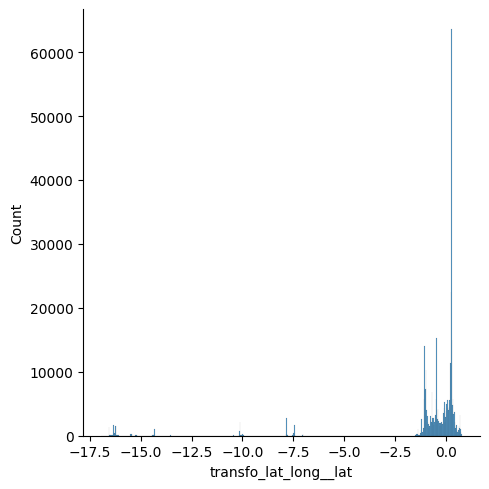

In [46]:
print(X_train_preprocessed.transfo_lat_long__lat.min())
print(X_train_preprocessed.transfo_lat_long__lat.max())
print(X_train_preprocessed.transfo_lat_long__lat.mean())

print(X_train_preprocessed.transfo_lat_long__long.min())
print(X_train_preprocessed.transfo_lat_long__long.max())
print(X_train_preprocessed.transfo_lat_long__long.mean())

sns.displot(X_train_preprocessed.transfo_lat_long__lat);

# KNN - tests

https://stats.stackexchange.com/questions/341/knn-and-unbalanced-classes

In [47]:
#Création du classifieur et construction du modèle sur les données d'entraînement
knn = neighbors.KNeighborsClassifier(n_neighbors=7, metric='minkowski', n_jobs=-1)
knn.fit(X_train_preprocessed, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=7)

In [48]:
y_pred = knn.predict(X_test_preprocessed)

In [49]:
print(knn.score(X_test_preprocessed, y_test))

0.6353491076620298


In [50]:
cr = classification_report(y_true=y_test, y_pred=y_pred)
print(cr)

              precision    recall  f1-score   support

           1       0.69      0.81      0.74     36910
           2       0.61      0.62      0.62     36078
           3       0.48      0.32      0.38     14000
           4       0.30      0.05      0.09      2440

    accuracy                           0.64     89428
   macro avg       0.52      0.45      0.46     89428
weighted avg       0.62      0.64      0.62     89428



In [51]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.69      0.81      0.74      0.74      0.78      0.61     36910
          2       0.61      0.62      0.74      0.62      0.68      0.45     36078
          3       0.48      0.32      0.94      0.38      0.54      0.28     14000
          4       0.30      0.05      1.00      0.09      0.23      0.05      2440

avg / total       0.62      0.64      0.78      0.62      0.68      0.48     89428



In [19]:
#Création du classifieur et construction du modèle sur les données d'entraînement
knn_dist = neighbors.KNeighborsClassifier(n_neighbors=7, metric='minkowski', n_jobs=-1, weights='distance')
knn_dist.fit(X_train_preprocessed, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=7, weights='distance')

In [20]:
y_pred_dist = knn_dist.predict(X_test_preprocessed)

In [21]:
cr = classification_report(y_true=y_test, y_pred=y_pred_dist)
print(cr)

              precision    recall  f1-score   support

           1       0.70      0.79      0.74     36910
           2       0.62      0.63      0.62     36078
           3       0.48      0.35      0.40     14000
           4       0.28      0.08      0.13      2440

    accuracy                           0.64     89428
   macro avg       0.52      0.46      0.47     89428
weighted avg       0.62      0.64      0.62     89428



In [22]:
print(classification_report_imbalanced(y_test, y_pred_dist))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.70      0.79      0.76      0.74      0.78      0.60     36910
          2       0.62      0.63      0.74      0.62      0.68      0.46     36078
          3       0.48      0.35      0.93      0.40      0.57      0.31     14000
          4       0.28      0.08      0.99      0.13      0.28      0.07      2440

avg / total       0.62      0.64      0.78      0.62      0.69      0.48     89428



## KNN : Rééquilibrer les classes par undersampling

In [155]:
# Pour mieux prédire les tués, il faut rééquilibrer les classes (pas fait automatiquement), et utiliser les variables de la base avec toutes les dummies
#Random Undersampling
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train_preprocessed, y_train)
print('Classes échantillon undersampled :', dict(pd.Series(y_ru).value_counts()))

Classes échantillon undersampled : {1: 9761, 2: 9761, 3: 9761, 4: 9761}


## Modèle de référence

In [156]:
#Création du classifieur et construction du modèle sur les données d'entraînement
#knn_dist = neighbors.KNeighborsClassifier(n_neighbors=7, metric='minkowski', n_jobs=-1, weights='distance')
#knn_dist.fit(X_ru, y_ru)

knn_ref = neighbors.KNeighborsClassifier(n_jobs=-1)
knn_ref.fit(X_ru, y_ru)

KNeighborsClassifier(n_jobs=-1)

In [157]:
# prédiction
y_pred_ref = knn_ref.predict(X_test_preprocessed)

In [158]:
print(classification_report_imbalanced(y_test, y_pred_ref))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.69      0.73      0.77      0.71      0.75      0.56     36910
          2       0.61      0.43      0.81      0.51      0.59      0.34     36078
          3       0.34      0.37      0.87      0.35      0.56      0.30     14000
          4       0.12      0.46      0.91      0.19      0.64      0.39      2440

avg / total       0.59      0.55      0.80      0.56      0.65      0.43     89428



In [159]:
pd.crosstab(y_test, y_pred_ref, rownames=['Classe réelle'], colnames=['Classe prédite'], normalize=0).round(2)

Classe prédite,1,2,3,4
Classe réelle,,,,
1,0.73,0.16,0.06,0.05
2,0.29,0.43,0.19,0.08
3,0.12,0.27,0.37,0.25
4,0.09,0.16,0.30,0.46


In [160]:
pd.crosstab(y_test, y_pred_ref, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1,2,3,4
Classe réelle,,,,
1,26983,5905,2318,1704
2,10361,15677,7031,3009
3,1626,3781,5131,3462
4,209,379,740,1112


## Optimisation avec GridSearchCV

In [60]:
from joblib import dump, load

In [161]:
#Grid search
from sklearn.model_selection import GridSearchCV

knn = neighbors.KNeighborsClassifier(n_jobs=-1, metric = 'minkowski')

#params =  {'n_neighbors':[i for i in range(5,35,2)], "p" : [i for i in range(1, 5)], 'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'] } 
params =  {'n_neighbors':[i for i in range(5,30,5)], 
           'weights' : ['uniform','distance'],
           "p" : [i for i in range(1, 2)]} 
crossval = StratifiedKFold(n_splits = 5)

grid_knn = GridSearchCV(knn, params, cv=crossval, scoring='f1_weighted', n_jobs=-1)
grid_knn.fit(X_ru, y_ru)

grid_knn.best_params_

{'n_neighbors': 25, 'p': 1, 'weights': 'distance'}

In [162]:
dump(grid_knn, conf['local_data_path'] + 'grid_knn.joblib')

['C:/Users/c.pelat/Lecteur_D/perso/formation/Datascientest/projet/data/PROJET_DS_Accidents/grid_knn.joblib']

In [163]:
params

{'n_neighbors': [5, 10, 15, 20, 25],
 'weights': ['uniform', 'distance'],
 'p': [1]}

## Afficher les performances des différente paramétrisation du modèle

In [166]:
print(pd.DataFrame.from_dict(grid_knn.cv_results_).loc[:,['params', 'mean_test_score']]) 

                                              params  mean_test_score
0   {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}         0.494982
1  {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}         0.502832
2  {'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}         0.511296
3  {'n_neighbors': 10, 'p': 1, 'weights': 'distan...         0.518586
4  {'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}         0.516485
5  {'n_neighbors': 15, 'p': 1, 'weights': 'distan...         0.523503
6  {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'}         0.521149
7  {'n_neighbors': 20, 'p': 1, 'weights': 'distan...         0.526885
8  {'n_neighbors': 25, 'p': 1, 'weights': 'uniform'}         0.523219
9  {'n_neighbors': 25, 'p': 1, 'weights': 'distan...         0.528154


## Récupération du meilleur modèle KNN

In [167]:
optimal_knn = grid_knn.best_estimator_
y_pred_gs = optimal_knn.predict(X_test_preprocessed)

In [168]:
print(classification_report_imbalanced(y_test, y_pred_gs))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.70      0.78      0.77      0.74      0.77      0.60     36910
          2       0.68      0.42      0.86      0.52      0.60      0.35     36078
          3       0.36      0.36      0.88      0.36      0.57      0.30     14000
          4       0.12      0.58      0.88      0.20      0.72      0.50      2440

avg / total       0.62      0.57      0.83      0.58      0.67      0.45     89428



In [66]:
# Pour comparaison : on remet le modele de reference
print(classification_report_imbalanced(y_test, y_pred_ref))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.69      0.74      0.77      0.71      0.75      0.57     36910
          2       0.62      0.45      0.81      0.52      0.60      0.35     36078
          3       0.34      0.36      0.87      0.35      0.56      0.30     14000
          4       0.12      0.47      0.91      0.19      0.65      0.41      2440

avg / total       0.59      0.55      0.81      0.56      0.66      0.43     89428



In [169]:
pd.crosstab(y_test, y_pred_gs, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1,2,3,4
Classe réelle,,,,
1,28784,4029,1930,2167
2,10507,15254,6567,3750
3,1421,3015,5110,4454
4,176,226,611,1427


In [170]:
pd.crosstab(y_test, y_pred_gs, rownames=['Classe réelle'], colnames=['Classe prédite'], normalize=0).round(2)

Classe prédite,1,2,3,4
Classe réelle,,,,
1,0.78,0.11,0.05,0.06
2,0.29,0.42,0.18,0.10
3,0.10,0.22,0.36,0.32
4,0.07,0.09,0.25,0.58


# Feature selection 
## On conserve uniquement les variables les plus importantes dans la meilleur  Random Forest

In [132]:
### Les 10 plus importantes features
import re
r_col = re.compile("one_hot_encoder__col")
r_place = re.compile("one_hot_encoder__place_rec")
r_obsm = re.compile("one_hot_encoder__obsm")
r_catv = re.compile("one_hot_encoder__catv")
r_catr = re.compile("one_hot_encoder__catr")
r_situ = re.compile("one_hot_encoder__situ")
r_heure = re.compile("heure")
r_prox_pt_choc = re.compile("prox_pt_choc")
r_mois = re.compile("mois")
r_lum = re.compile("one_hot_encoder__lum")
r_motor = re.compile("one_hot_encoder__motor")

selected_feats = ["remainder__eq_ceinture", 
            "transfo_age_usager__age_usager", 
             "remainder__agg", 
             "transfo_lat_long__lat",
             "remainder__obs", 
             "transfo_lat_long__long",
              "remainder__eq_casque",
              'remainder__circ',
              'remainder__sexe'
            ]

for mycol in X_ru.columns:
    if(len(r_col.findall(mycol))) > 0:
        selected_feats.append(mycol)

    if(len(r_place.findall(mycol))) > 0:
        selected_feats.append(mycol)

    if(len(r_obsm.findall(mycol))) > 0:
        selected_feats.append(mycol)

    if(len(r_catv.findall(mycol))) > 0:
        selected_feats.append(mycol)

    if(len(r_catr.findall(mycol))) > 0:
        selected_feats.append(mycol)
    
    if(len(r_situ.findall(mycol))) > 0:
        selected_feats.append(mycol)
    
    if(len(r_heure.findall(mycol))) > 0:
        selected_feats.append(mycol)

    if(len(r_lum.findall(mycol))) > 0:
        selected_feats.append(mycol)

    if(len(r_motor.findall(mycol))) > 0:
        selected_feats.append(mycol)

selected_feats

['remainder__eq_ceinture',
 'transfo_age_usager__age_usager',
 'remainder__agg',
 'transfo_lat_long__lat',
 'remainder__obs',
 'transfo_lat_long__long',
 'remainder__eq_casque',
 'remainder__circ',
 'remainder__sexe',
 'transfo_heure__heure_sin',
 'transfo_heure__heure_cos',
 'one_hot_encoder__lum_0.0',
 'one_hot_encoder__lum_1.0',
 'one_hot_encoder__lum_2.0',
 'one_hot_encoder__lum_3.0',
 'one_hot_encoder__col_1.0',
 'one_hot_encoder__col_2.0',
 'one_hot_encoder__col_3.0',
 'one_hot_encoder__col_4.0',
 'one_hot_encoder__col_5.0',
 'one_hot_encoder__col_6.0',
 'one_hot_encoder__col_7.0',
 'one_hot_encoder__catr_1',
 'one_hot_encoder__catr_2',
 'one_hot_encoder__catr_3',
 'one_hot_encoder__catr_4',
 'one_hot_encoder__catr_5',
 'one_hot_encoder__catr_6',
 'one_hot_encoder__catr_7',
 'one_hot_encoder__catr_9',
 'one_hot_encoder__situ_1.0',
 'one_hot_encoder__situ_2.0',
 'one_hot_encoder__situ_3.0',
 'one_hot_encoder__situ_4.0',
 'one_hot_encoder__situ_5.0',
 'one_hot_encoder__situ_6.0',
 

In [136]:
knn_20 = neighbors.KNeighborsClassifier(n_jobs=-1, n_neighbors=25, metric = 'minkowski', p = 1, weights = 'distance')
knn_20.fit(X_ru.loc[:, selected_feats], y_ru)

KNeighborsClassifier(n_jobs=-1, n_neighbors=25, p=1, weights='distance')

In [137]:
# prédiction
y_pred_20 = knn_20.predict(X_test_preprocessed.loc[:, selected_feats])

In [138]:
# performance
print(classification_report_imbalanced(y_test, y_pred_20))


                   pre       rec       spe        f1       geo       iba       sup

          1       0.71      0.76      0.79      0.74      0.77      0.60     36910
          2       0.67      0.45      0.85      0.54      0.62      0.36     36078
          3       0.36      0.36      0.88      0.36      0.56      0.30     14000
          4       0.12      0.59      0.88      0.20      0.72      0.51      2440

avg / total       0.62      0.57      0.83      0.58      0.68      0.45     89428



In [142]:
display(pd.crosstab(y_test, y_pred_20, rownames=['Classe réelle'], colnames=['Classe prédite']))

Classe prédite,1,2,3,4
Classe réelle,,,,
1,28116,4526,2062,2206
2,9770,16148,6292,3868
3,1307,3221,4993,4479
4,159,276,561,1444


In [143]:
display(pd.crosstab(y_test, y_pred_20, rownames=['Classe réelle'], colnames=['Classe prédite'], normalize=0).round(2))


Classe prédite,1,2,3,4
Classe réelle,,,,
1,0.76,0.12,0.06,0.06
2,0.27,0.45,0.17,0.11
3,0.09,0.23,0.36,0.32
4,0.07,0.11,0.23,0.59
